In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
import scipy.stats as stats
import math
import statistics

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
livetime = 8 * u.h
n_obs = 125
l = 0.3
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [7]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=l * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s



In [9]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 3375 
    Total predicted counts          : nan
    Total background counts         : 3384.90

    Effective area min              : 5.09e+04 m2
    Effective area max              : 5.15e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [11]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 5766 
    Total predicted counts          : 5839.41
    Total off counts                : 17008.00

    Total background counts         : 3401.60

    Effective area min              : 5.09e+04 m2
    Effective area max              : 5.15e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [12]:
%%time

datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 783 ms, sys: 2.81 ms, total: 785 ms
Wall time: 1.16 s


Text(0, 0.5, 'No. of observations')

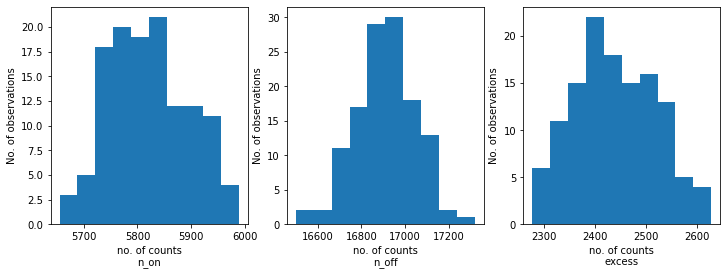

In [13]:
n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:
%%time
results = []
fpes = []
e_edges = np.logspace(-1.5, 2.0, 10) * u.TeV
model_best_joints = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.run()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "reference":result.parameters["reference"].value,
            "lambda_": result.parameters["lambda_"].value,
            "alpha":result.parameters["alpha"].value,
        }
    )
    print(result.parameters.to_table())
    fpe = FluxPointsEstimator(datasets=[dataset], e_edges=e_edges)
    flux_points = fpe.run()
    print(flux_points.table_formatted)
    fpes.append(flux_points)
    model_best_joint = model.copy()
    model_best_joint.spectral_model.parameters.covariance = (result.parameters.covariance)
    model_best_joints.append(model_best_joint)

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.217e+00 4.006e-02                nan nan  False
amplitude 1.297e-12 1.042e-13 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 2.674e-01 4.559e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.967e-11       9.017e-11       8.918e-11
 0.121  0.077   0.190 ...       7.655e-12       7.692e-12       7.618e-12
 0.297  0.190   0.464 ...       9.283e-13       9.380e-13       9.186e-13
 0.726  0.464   1.136 ...       1.413e-13       1.436e-13       1.390e-13
 1.778  1.136   2.783 ...       1.901e-14       1.944e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.934e-11       8.979e-11       8.891e-11
 0.121  0.077   0.190 ...       7.643e-12       7.686e-12       7.601e-12
 0.297  0.190   0.464 ...       9.385e-13       9.467e-13       9.303e-13
 0.726  0.464   1.136 ...       1.394e-13       1.417e-13       1.371e-13
 1.778  1.136   2.783 ...       1.732e-14       1.774e-14       1.691e-14
 4.354  2.783   6.813 ...       2.132e-15       2.225e-15       2.042e-15
10.661  6.813  16.681 ...       2.641e-16       2.899e-16       2.401e-16
26.102 16.681  40.842 ...       1.190e-20       8.449e-18       4.191e-24
63.908 40.842 100.000 ...       1.512e-23       9.581e-20       1.711e-28
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.282e+00 3.808e-02                nan nan  False
amplitude 1.164e-12 9.120e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 2.250e-01 4.301e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.978e-11       9.012e-11       8.945e-11
 0.121  0.077   0.190 ...       7.658e-12       7.696e-12       7.621e-12
 0.297  0.190   0.464 ...       9.271e-13       9.348e-13       9.194e-13
 0.726  0.464   1.136 ...       1.399e-13       1.421e-13       1.376e-13
 1.778  1.136   2.783 ...       1.756e-14       1.798e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.852e-11       8.847e-11       8.859e-11
 0.121  0.077   0.190 ...       7.706e-12       7.761e-12       7.652e-12
 0.297  0.190   0.464 ...       9.385e-13       9.445e-13       9.324e-13
 0.726  0.464   1.136 ...       1.440e-13       1.463e-13       1.418e-13
 1.778  1.136   2.783 ...       1.721e-14       1.764e-14       1.680e-14
 4.354  2.783   6.813 ...       2.071e-15       2.163e-15       1.983e-15
10.661  6.813  16.681 ...       1.460e-16       1.687e-16       1.266e-16
26.102 16.681  40.842 ...       3.574e-21       5.145e-18       6.192e-25
63.908 40.842 100.000 ...       5.484e-25       6.264e-22       1.118e-30
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.179e+00 4.338e-02                nan nan  False
amplitude 1.472e-12 1.332e-13 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 3.623e-01 5.866e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.929e-11       8.968e-11       8.892e-11
 0.121  0.077   0.190 ...       7.756e-12       7.769e-12       7.742e-12
 0.297  0.190   0.464 ...       9.692e-13       9.773e-13       9.611e-13
 0.726  0.464   1.136 ...       1.403e-13       1.428e-13       1.379e-13
 1.778  1.136   2.783 ...       1.836e-14       1.894e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.995e-11       9.039e-11       8.952e-11
 0.121  0.077   0.190 ...       7.691e-12       7.736e-12       7.646e-12
 0.297  0.190   0.464 ...       9.349e-13       9.444e-13       9.254e-13
 0.726  0.464   1.136 ...       1.395e-13       1.417e-13       1.373e-13
 1.778  1.136   2.783 ...       1.622e-14       1.676e-14       1.571e-14
 4.354  2.783   6.813 ...       2.134e-15       2.226e-15       2.046e-15
10.661  6.813  16.681 ...       1.868e-16       2.112e-16       1.650e-16
26.102 16.681  40.842 ...       6.531e-21       6.757e-18       1.576e-24
63.908 40.842 100.000 ...       3.144e-24       8.565e-21       1.529e-29
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.264e+00 3.749e-02                nan nan  False
amplitude 1.197e-12 9.182e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 2.248e-01 4.159e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.834e-11       8.864e-11       8.804e-11
 0.121  0.077   0.190 ...       7.742e-12       7.800e-12       7.685e-12
 0.297  0.190   0.464 ...       9.321e-13       9.416e-13       9.227e-13
 0.726  0.464   1.136 ...       1.387e-13       1.411e-13       1.365e-13
 1.778  1.136   2.783 ...       1.781e-14       1.823e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.840e-11       8.883e-11       8.797e-11
 0.121  0.077   0.190 ...       7.701e-12       7.764e-12       7.638e-12
 0.297  0.190   0.464 ...       9.289e-13       9.385e-13       9.193e-13
 0.726  0.464   1.136 ...       1.381e-13       1.402e-13       1.360e-13
 1.778  1.136   2.783 ...       1.842e-14       1.892e-14       1.792e-14
 4.354  2.783   6.813 ...       2.122e-15       2.211e-15       2.034e-15
10.661  6.813  16.681 ...       1.845e-16       2.082e-16       1.632e-16
26.102 16.681  40.842 ...       5.597e-21       6.031e-18       1.297e-24
63.908 40.842 100.000 ...       1.562e-24       3.196e-21       5.706e-30
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.225e+00 4.172e-02                nan nan  False
amplitude 1.259e-12 1.064e-13 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 2.754e-01 4.892e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.983e-11       9.026e-11       8.940e-11
 0.121  0.077   0.190 ...       7.528e-12       7.578e-12       7.478e-12
 0.297  0.190   0.464 ...       9.308e-13       9.403e-13       9.213e-13
 0.726  0.464   1.136 ...       1.430e-13       1.453e-13       1.407e-13
 1.778  1.136   2.783 ...       1.809e-14       1.854e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.861e-11       8.837e-11       8.886e-11
 0.121  0.077   0.190 ...       7.676e-12       7.678e-12       7.675e-12
 0.297  0.190   0.464 ...       9.386e-13       9.484e-13       9.288e-13
 0.726  0.464   1.136 ...       1.379e-13       1.400e-13       1.359e-13
 1.778  1.136   2.783 ...       1.800e-14       1.859e-14       1.744e-14
 4.354  2.783   6.813 ...       1.910e-15       1.997e-15       1.826e-15
10.661  6.813  16.681 ...       1.838e-16       2.050e-16       1.650e-16
26.102 16.681  40.842 ...       2.110e-21       4.021e-18       2.758e-25
63.908 40.842 100.000 ...       1.207e-25       6.568e-23       1.173e-31
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.207e+00 4.472e-02                nan nan  False
amplitude 1.296e-12 1.185e-13 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 3.333e-01 5.667e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.999e-11       9.043e-11       8.955e-11
 0.121  0.077   0.190 ...       7.523e-12       7.574e-12       7.473e-12
 0.297  0.190   0.464 ...       9.244e-13       9.295e-13       9.193e-13
 0.726  0.464   1.136 ...       1.413e-13       1.436e-13       1.390e-13
 1.778  1.136   2.783 ...       1.759e-14       1.813e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.915e-11       8.950e-11       8.880e-11
 0.121  0.077   0.190 ...       7.584e-12       7.635e-12       7.533e-12
 0.297  0.190   0.464 ...       9.646e-13       9.747e-13       9.546e-13
 0.726  0.464   1.136 ...       1.434e-13       1.457e-13       1.411e-13
 1.778  1.136   2.783 ...       1.771e-14       1.813e-14       1.729e-14
 4.354  2.783   6.813 ...       1.863e-15       1.950e-15       1.778e-15
10.661  6.813  16.681 ...       1.996e-16       2.213e-16       1.796e-16
26.102 16.681  40.842 ...       1.795e-21       3.650e-18       2.195e-25
63.908 40.842 100.000 ...       6.981e-26       2.977e-23       5.315e-32
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.217e+00 4.175e-02                nan nan  False
amplitude 1.251e-12 1.084e-13 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 2.845e-01 5.146e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.755e-11       8.797e-11       8.713e-11
 0.121  0.077   0.190 ...       7.671e-12       7.730e-12       7.613e-12
 0.297  0.190   0.464 ...       9.669e-13       9.773e-13       9.567e-13
 0.726  0.464   1.136 ...       1.339e-13       1.355e-13       1.323e-13
 1.778  1.136   2.783 ...       1.754e-14       1.796e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.867e-11       8.920e-11       8.817e-11
 0.121  0.077   0.190 ...       7.502e-12       7.529e-12       7.474e-12
 0.297  0.190   0.464 ...       9.215e-13       9.305e-13       9.126e-13
 0.726  0.464   1.136 ...       1.397e-13       1.420e-13       1.374e-13
 1.778  1.136   2.783 ...       1.741e-14       1.787e-14       1.696e-14
 4.354  2.783   6.813 ...       2.438e-15       2.530e-15       2.349e-15
10.661  6.813  16.681 ...       2.012e-16       2.262e-16       1.792e-16
26.102 16.681  40.842 ...       1.277e-20       8.455e-18       4.815e-24
63.908 40.842 100.000 ...       1.536e-23       1.029e-19       1.835e-28
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.153e+00 4.430e-02                nan nan  False
amplitude 1.465e-12 1.317e-13 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 3.568e-01 5.648e-02          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.894e-11       8.938e-11       8.850e-11
 0.121  0.077   0.190 ...       7.720e-12       7.774e-12       7.665e-12
 0.297  0.190   0.464 ...       9.434e-13       9.467e-13       9.400e-13
 0.726  0.464   1.136 ...       1.454e-13       1.478e-13       1.431e-13
 1.778  1.136   2.783 ...       1.903e-14       1.956e-14     

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.822e-11       8.865e-11       8.778e-11
 0.121  0.077   0.190 ...       7.717e-12       7.777e-12       7.658e-12
 0.297  0.190   0.464 ...       9.371e-13       9.462e-13       9.280e-13
 0.726  0.464   1.136 ...       1.387e-13       1.408e-13       1.366e-13
 1.778  1.136   2.783 ...       1.701e-14       1.746e-14       1.657e-14
 4.354  2.783   6.813 ...       1.793e-15       1.880e-15       1.708e-15
10.661  6.813  16.681 ...       1.353e-16       1.537e-16       1.246e-17
26.102 16.681  40.842 ...       1.106e-21       3.085e-18       9.906e-26
63.908 40.842 100.000 ...       2.352e-26       5.476e-24       9.775e-33
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.906e-11       8.926e-11       8.886e-11
 0.121  0.077   0.190 ...       7.759e-12       7.800e-12       7.717e-12
 0.297  0.190   0.464 ...       9.498e-13       9.597e-13       9.400e-13
 0.726  0.464   1.136 ...       1.404e-13       1.428e-13       1.381e-13
 1.778  1.136   2.783 ...       1.758e-14       1.802e-14       1.716e-14
 4.354  2.783   6.813 ...       1.870e-15       1.958e-15       1.785e-15
10.661  6.813  16.681 ...       1.494e-16       1.705e-16       1.310e-16
26.102 16.681  40.842 ...       1.591e-21       3.569e-18       1.774e-25
63.908 40.842 100.000 ...       5.750e-26       2.144e-23       3.828e-32
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.893e-11       8.935e-11       8.853e-11
 0.121  0.077   0.190 ...       7.585e-12       7.621e-12       7.548e-12
 0.297  0.190   0.464 ...       9.122e-13       9.161e-13       9.082e-13
 0.726  0.464   1.136 ...       1.381e-13       1.401e-13       1.361e-13
 1.778  1.136   2.783 ...       1.609e-14       1.658e-14       1.560e-14
 4.354  2.783   6.813 ...       2.142e-15       2.231e-15       2.055e-15
10.661  6.813  16.681 ...       2.257e-16       2.509e-16       2.028e-16
26.102 16.681  40.842 ...       1.106e-20       8.430e-18       3.625e-24
63.908 40.842 100.000 ...       1.432e-23       8.484e-20       1.514e-28
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.049  0.032   0.077 ...       8.918e-11       8.933e-11       8.903e-11
 0.121  0.077   0.190 ...       7.588e-12       7.641e-12       7.536e-12
 0.297  0.190   0.464 ...       9.172e-13       9.248e-13       9.095e-13
 0.726  0.464   1.136 ...       1.388e-13       1.411e-13       1.365e-13
 1.778  1.136   2.783 ...       1.800e-14       1.849e-14       1.753e-14
 4.354  2.783   6.813 ...       2.179e-15       2.280e-15       2.082e-15
10.661  6.813  16.681 ...       2.307e-16       2.550e-16       2.082e-16
26.102 16.681  40.842 ...       1.784e-17       2.423e-17       1.246e-17
63.908 40.842 100.000 ...       2.255e-23       1.812e-19       3.235e-28
   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- ---

index: 2.222187041863254 += 0.046117118252728496


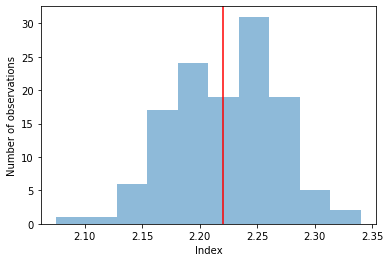

In [15]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel('Index')
plt.ylabel('Number of observations')
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2906129215004001e-12 += 1.2216410557449558e-13


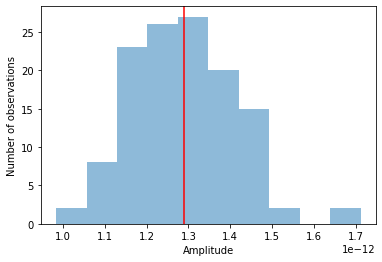

In [16]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel('Amplitude')
plt.ylabel('Number of observations')
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

In [17]:
reference = np.array([_["reference"] for _ in results])
lambda_ = np.array([_["lambda_"] for _ in results])
alpha = np.array([_["alpha"] for _ in results])
x = np.array([index, amplitude, reference, lambda_, alpha])
covar=np.cov(x)
print(covar)

[[ 2.14394012e-03 -5.28713560e-15  0.00000000e+00 -2.33345084e-03
   0.00000000e+00]
 [-5.28713560e-15  1.50444241e-26  0.00000000e+00  6.50361956e-15
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.33345084e-03  6.50361956e-15  0.00000000e+00  3.44757800e-03
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


In [18]:
simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [19]:
i = 0
fpes[i].table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049,0.032,0.077,1.004e-09,4.675e-11,2.204e-12,2.458e-12,1.053,0.000,0.089,2831,0.090,0.089,1.234,12.528,156.955,0.200 .. 5.000,100.630 .. 1352.191,1.058e-09,1.239e-09,8.967e-11,9.017e-11,8.918e-11
0.121,0.077,0.190,1.353e-10,1.544e-11,1.780e-12,1.986e-12,1.018,0.000,0.057,1608,0.057,0.056,1.133,20.672,427.328,0.200 .. 5.000,260.281 .. 2506.534,1.377e-10,1.532e-10,7.655e-12,7.692e-12,7.618e-12
0.297,0.190,0.464,1.773e-11,4.964e-12,1.397e-12,1.560e-12,0.944,0.000,0.052,794,0.053,0.052,1.051,22.660,513.461,0.200 .. 5.000,286.383 .. 2347.417,1.673e-11,1.863e-11,9.283e-13,9.380e-13,9.186e-13
0.726,0.464,1.136,2.170e-12,1.498e-12,1.024e-12,1.145e-12,0.961,0.000,0.065,358,0.066,0.064,1.096,20.341,413.771,0.200 .. 5.000,222.414 .. 1335.615,2.086e-12,2.378e-12,1.413e-13,1.436e-13,1.390e-13
1.778,1.136,2.783,2.250e-13,3.873e-13,6.372e-13,7.114e-13,1.127,0.000,0.085,216,0.086,0.083,1.303,20.784,431.975,0.200 .. 5.000,241.453 .. 742.530,2.535e-13,2.932e-13,1.901e-14,1.944e-14,1.859e-14
4.354,2.783,6.813,1.552e-14,6.973e-14,2.699e-13,2.941e-13,0.970,0.000,0.142,64,0.148,0.136,1.278,10.042,100.840,0.200 .. 5.000,52.622 .. 263.985,1.505e-14,1.982e-14,2.203e-15,2.293e-15,2.116e-15
10.661,6.813,16.681,3.946e-16,5.563e-15,4.875e-14,4.484e-14,0.526,0.000,0.438,5,0.497,0.386,1.652,1.433,2.054,0.200 .. 5.000,0.682 .. 29.897,2.074e-16,6.519e-16,1.727e-16,1.963e-16,1.523e-16
26.102,16.681,40.842,8.722e-19,7.613e-17,1.475e-15,5.942e-16,0.000,0.000,0.007,0,7.194,0.000,28.810,0.000,0.000,0.200 .. 5.000,0.028 .. 0.694,1.557e-24,2.513e-17,6.255e-21,6.274e-18,1.557e-24


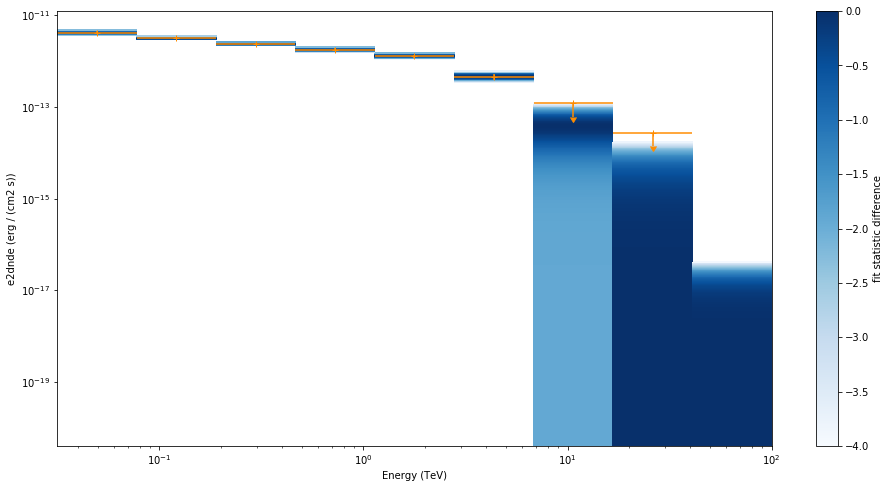

In [20]:
plt.figure(figsize=(16, 8))
fpes[i].table["is_ul"] = fpes[i].table["ts"] < 4
ax = fpes[i].plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
fpes[i].to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [21]:
flux_points_dataset = FluxPointsDataset(
    data=fpes[i], models=model_best_joints[i]
)

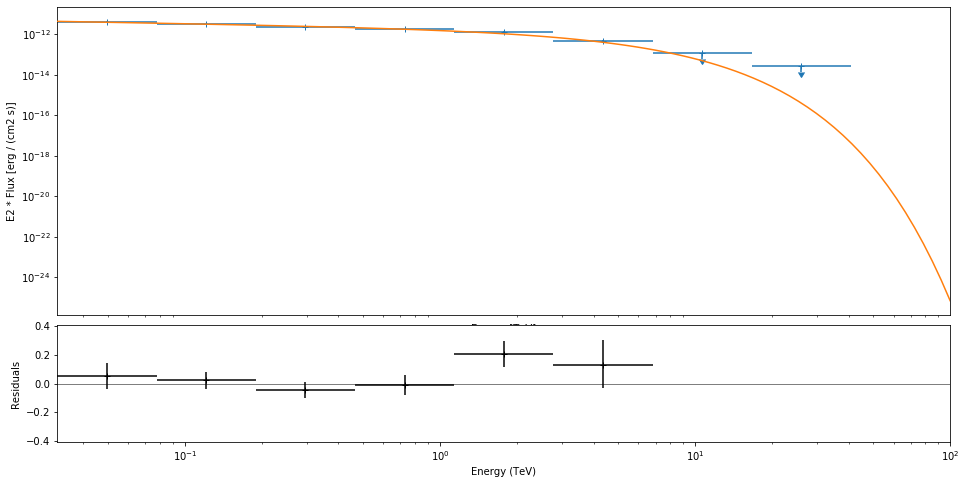

In [22]:
plt.figure(figsize=(16, 8))
flux_points_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

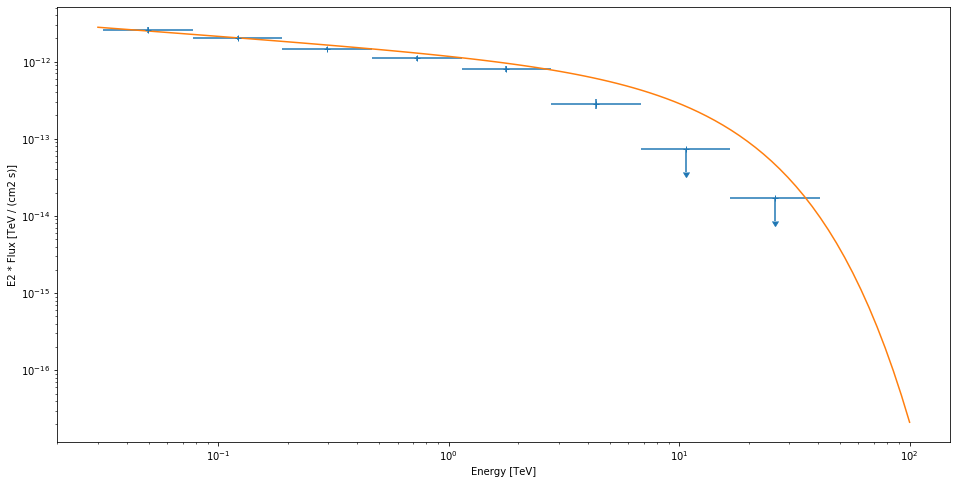

In [23]:
energy_range = [0.03, 100] * u.TeV
plt.figure(figsize=[16,8])
fpes[i].plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

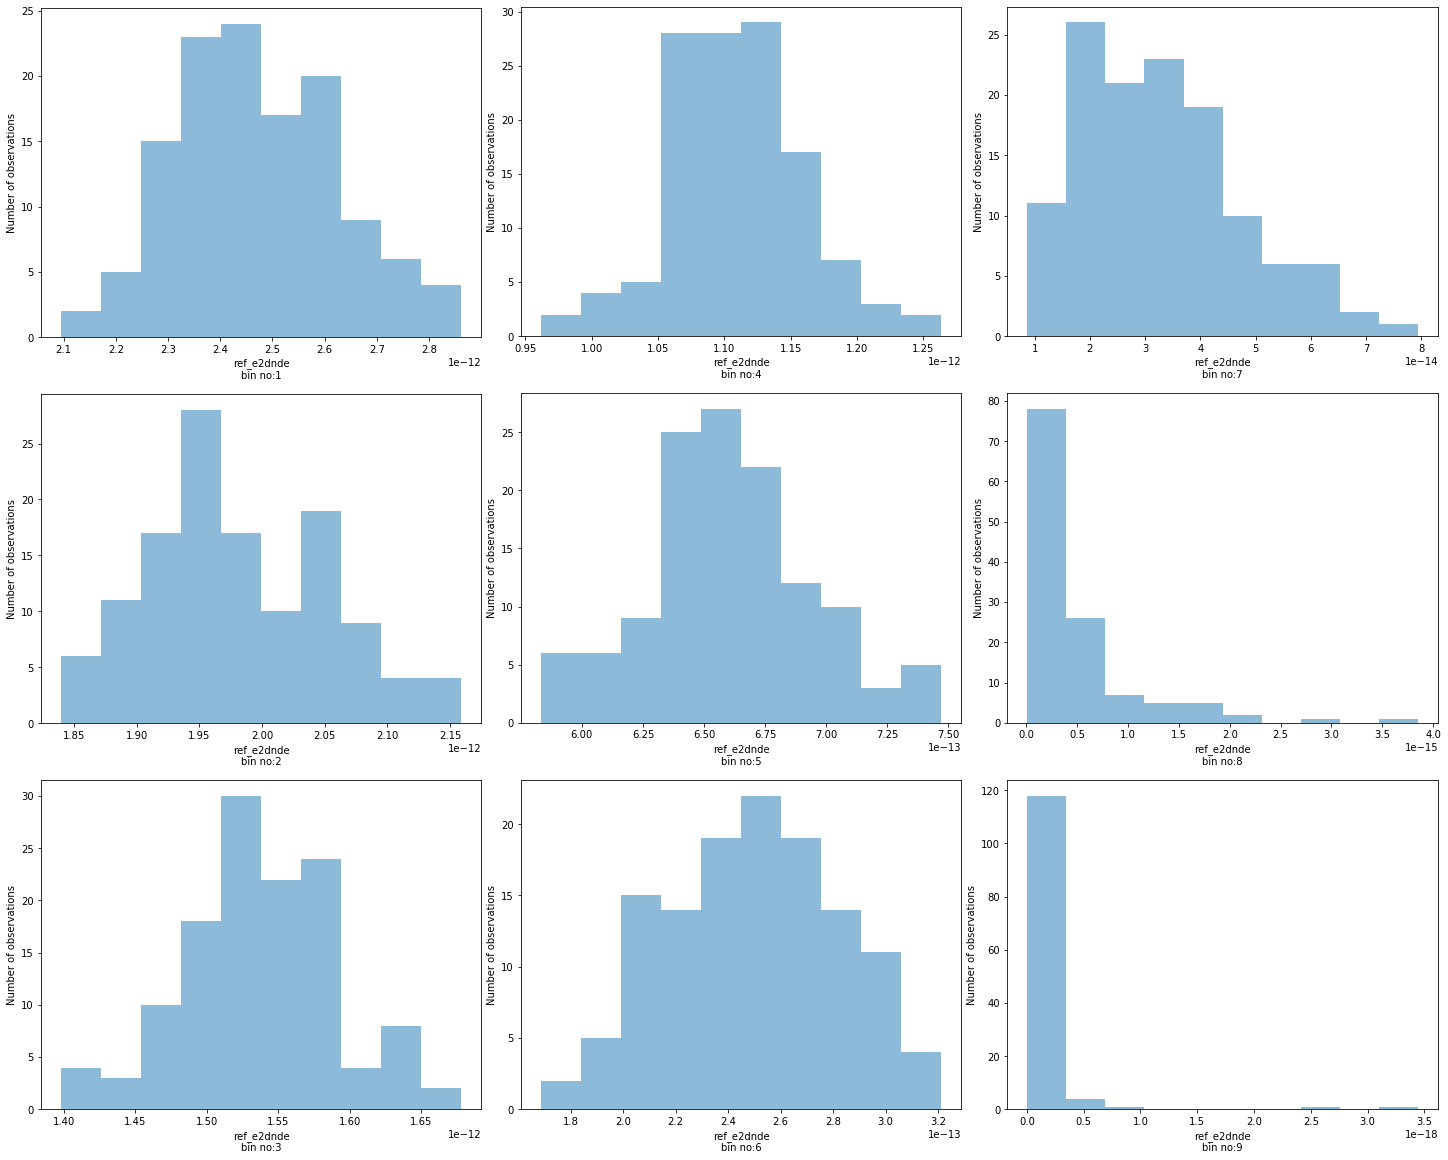

In [24]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['ref_e2dnde'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'ref_e2dnde\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

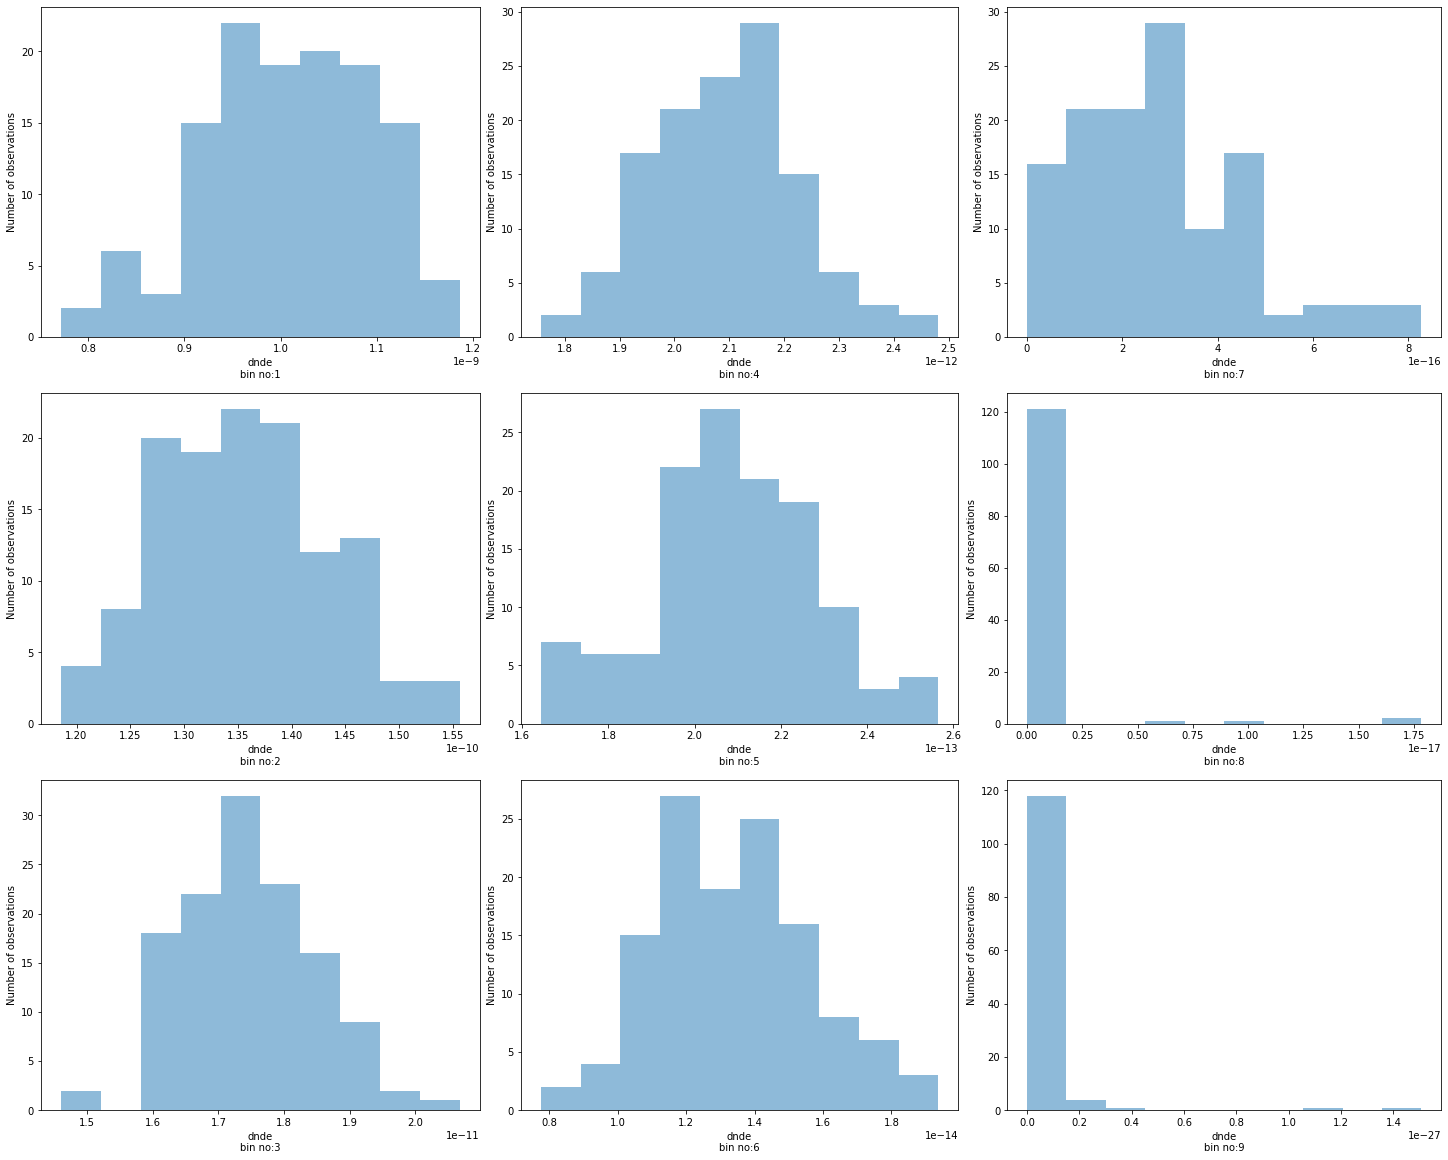

In [25]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['dnde'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['dnde'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['dnde'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'dnde\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

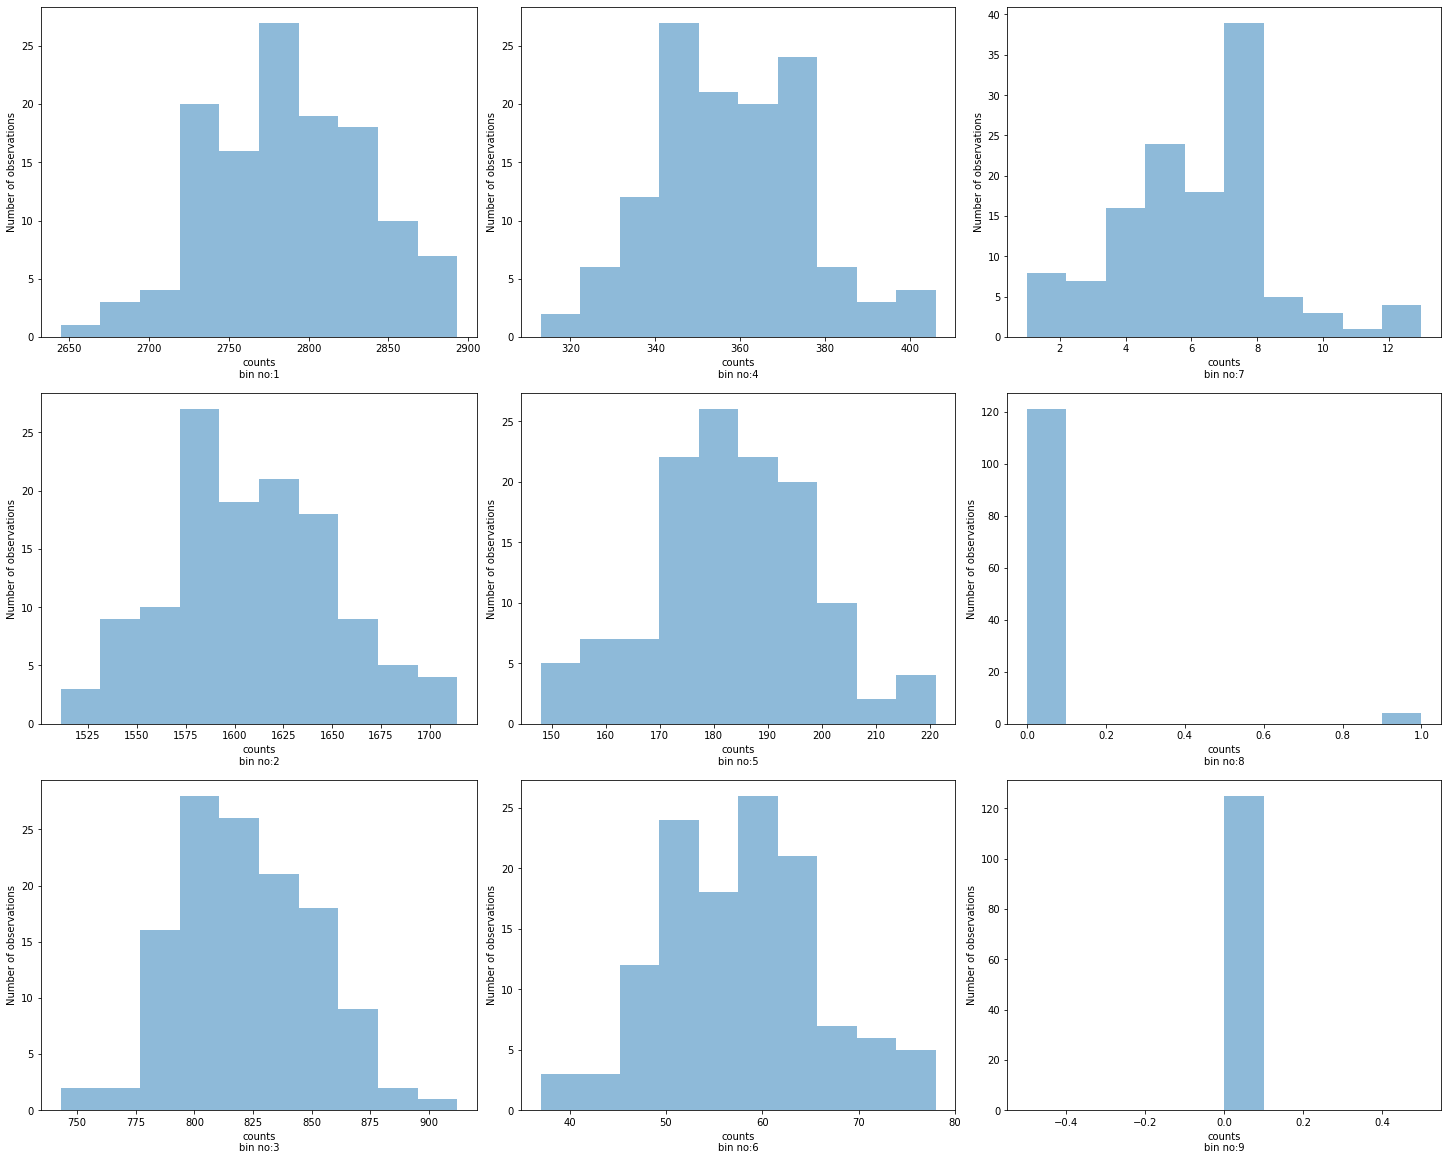

In [26]:
fig = plt.figure(figsize=[20,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(3):
    ax = fig.add_subplot(gs1[n])
    e_ref_first = np.array([_.table['counts'][n] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+1}')
    plt.ylabel('Number of observations')
    
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    e_ref_first = np.array([_.table['counts'][n+3] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+4}')
    plt.ylabel('Number of observations')

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(3):
    ax = fig.add_subplot(gs3[n])
    e_ref_first = np.array([_.table['counts'][n+6] for _ in fpes])
    plt.hist(e_ref_first, bins=10, alpha=0.5)
    plt.xlabel(f'counts\nbin no:{n+7}')
    plt.ylabel('Number of observations')

plt.show()

In [27]:
x = ['e_ref','e_min','e_max','ref_dnde','ref_flux','ref_eflux','ref_e2dnde','norm','stat','norm_err','norm_errp','norm_errn','norm_ul','sqrt_ts','ts','norm_scan','stat_scan','dnde','dnde_ul','dnde_err','dnde_errp','dnde_errn']

In [28]:
flux_points_mean = fpe.run()
flux_points_mean.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049,0.032,0.077,9.915e-10,4.620e-11,2.177e-12,2.428e-12,1.021,0.000,0.090,2822,0.091,0.090,1.203,11.965,143.172,0.200 .. 5.000,90.443 .. 1345.289,1.012e-09,1.193e-09,8.956e-11,8.976e-11,8.937e-11
0.121,0.077,0.190,1.324e-10,1.512e-11,1.741e-12,1.943e-12,0.987,0.000,0.058,1588,0.058,0.057,1.104,19.575,383.183,0.200 .. 5.000,230.168 .. 2469.965,1.306e-10,1.461e-10,7.614e-12,7.659e-12,7.570e-12
0.297,0.190,0.464,1.712e-11,4.800e-12,1.349e-12,1.506e-12,0.992,0.000,0.055,810,0.055,0.054,1.104,22.753,517.720,0.200 .. 5.000,298.186 .. 2178.925,1.699e-11,1.890e-11,9.372e-13,9.469e-13,9.276e-13
0.726,0.464,1.136,2.049e-12,1.417e-12,9.672e-13,1.081e-12,1.046,0.000,0.070,370,0.071,0.069,1.191,20.492,419.935,0.200 .. 5.000,238.828 .. 1182.945,2.143e-12,2.440e-12,1.436e-13,1.458e-13,1.414e-13
1.778,1.136,2.783,2.029e-13,3.514e-13,5.756e-13,6.418e-13,0.932,0.000,0.083,169,0.086,0.081,1.107,16.661,277.598,0.200 .. 5.000,139.896 .. 755.753,1.892e-13,2.246e-13,1.685e-14,1.735e-14,1.636e-14
4.354,2.783,6.813,1.264e-14,5.793e-14,2.222e-13,2.396e-13,1.110,0.000,0.167,60,0.175,0.159,1.473,9.822,96.478,0.200 .. 5.000,54.908 .. 197.025,1.403e-14,1.861e-14,2.109e-15,2.207e-15,2.015e-15
10.661,6.813,16.681,2.527e-16,3.838e-15,3.314e-14,2.872e-14,0.608,0.000,0.652,5,0.738,0.578,2.276,1.059,1.122,0.200 .. 5.000,0.463 .. 17.190,1.537e-16,5.751e-16,1.647e-16,1.865e-16,1.461e-16
26.102,16.681,40.842,3.129e-19,3.531e-17,6.751e-16,2.132e-16,0.000,0.000,0.011,0,15.748,0.000,63.156,0.000,0.000,0.200 .. 5.000,0.013 .. 0.317,5.587e-25,1.976e-17,3.323e-21,4.928e-18,5.587e-25


In [29]:
for _ in x:
    y = 0
    for bin in fpes:
        y = y + bin.table[_]
    y = y/len(fpes)
    flux_points_mean.table[_] = y
    
y = 0
for bin in fpes:
    y = y + bin.table['counts']
y = y/len(fpes)
flux_points_mean.table['counts'] = y.astype(int)

In [30]:
flux_points_mean.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049,0.032,0.077,1.010e-09,4.707e-11,2.218e-12,2.473e-12,0.996,0.000,0.088,2786,0.089,0.088,1.175,11.977,144.500,0.200 .. 5.000,90.265 .. 1418.324,1.006e-09,1.186e-09,8.899e-11,8.931e-11,8.868e-11
0.121,0.077,0.190,1.350e-10,1.541e-11,1.776e-12,1.981e-12,1.004,0.000,0.057,1608,0.057,0.056,1.119,20.278,412.426,0.200 .. 5.000,249.862 .. 2512.836,1.355e-10,1.510e-10,7.657e-12,7.700e-12,7.614e-12
0.297,0.190,0.464,1.750e-11,4.904e-12,1.379e-12,1.539e-12,1.000,0.000,0.054,821,0.054,0.053,1.110,23.404,549.074,0.200 .. 5.000,316.978 .. 2229.634,1.749e-11,1.941e-11,9.429e-13,9.508e-13,9.350e-13
0.726,0.464,1.136,2.101e-12,1.452e-12,9.916e-13,1.108e-12,0.996,0.000,0.067,358,0.068,0.066,1.135,20.444,418.974,0.200 .. 5.000,230.538 .. 1262.857,2.092e-12,2.384e-12,1.412e-13,1.434e-13,1.390e-13
1.778,1.136,2.783,2.089e-13,3.615e-13,5.925e-13,6.606e-13,0.999,0.000,0.084,183,0.086,0.082,1.176,17.947,323.412,0.200 .. 5.000,170.161 .. 746.907,2.088e-13,2.456e-13,1.752e-14,1.798e-14,1.708e-14
4.354,2.783,6.813,1.318e-14,6.026e-14,2.315e-13,2.499e-13,1.015,0.000,0.158,57,0.165,0.151,1.359,9.427,90.096,0.200 .. 5.000,48.731 .. 219.298,1.339e-14,1.788e-14,2.067e-15,2.158e-15,1.979e-15
10.661,6.813,16.681,2.913e-16,4.258e-15,3.709e-14,3.311e-14,0.947,0.007,0.642,6,0.758,0.533,2.670,1.834,4.431,0.200 .. 5.000,2.733 .. 17.549,2.761e-16,7.204e-16,1.720e-16,1.972e-16,1.454e-16
26.102,16.681,40.842,6.934e-19,5.538e-17,1.079e-15,4.724e-16,1.225,0.000,1.237,0,24.589,0.855,97.530,0.061,0.115,0.200 .. 5.000,0.128 .. 0.518,4.021e-19,2.205e-17,4.069e-19,5.597e-18,2.805e-19


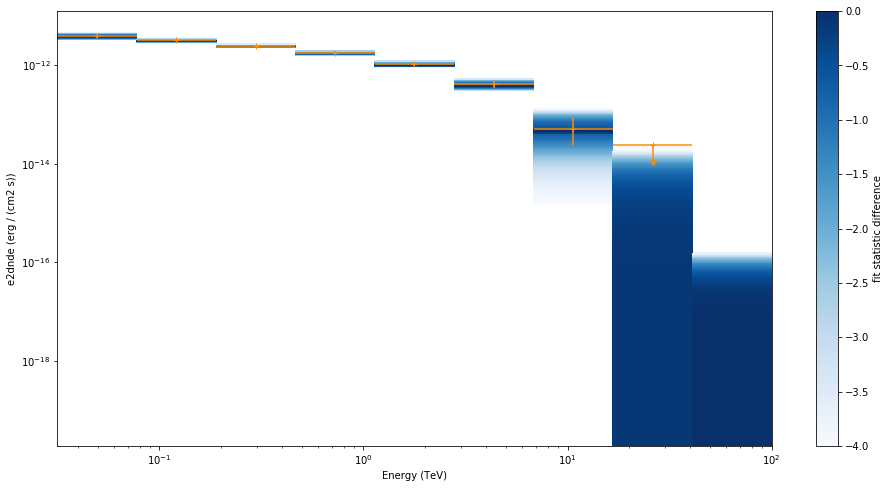

In [31]:
plt.figure(figsize=(16, 8))
flux_points_mean.table["is_ul"] = flux_points_mean.table["ts"] < 4
ax = flux_points_mean.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points_mean.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [32]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points_mean, models=model_best_joints[124]
)

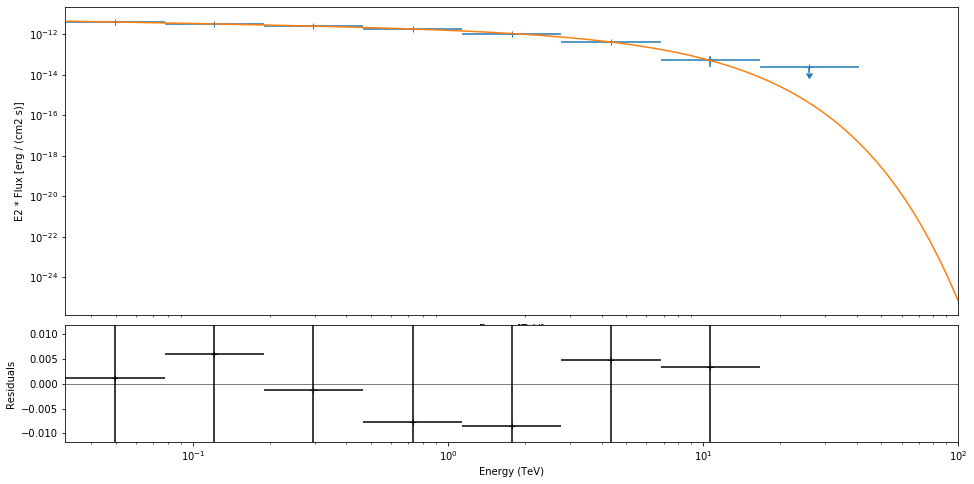

In [33]:
plt.figure(figsize=(16, 8))
flux_points_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

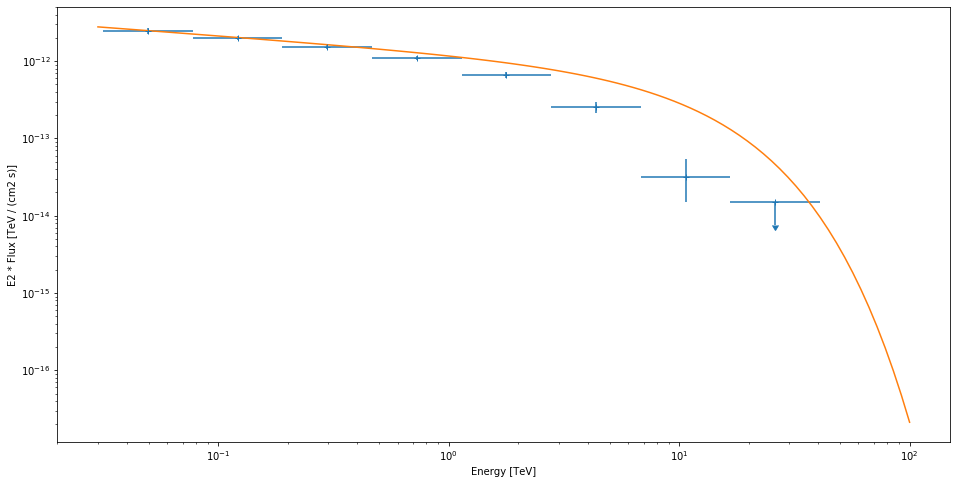

In [34]:
plt.figure(figsize=[16,8])
flux_points_mean.plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show

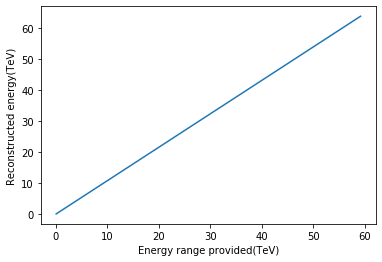

In [35]:
plt.plot(energy_axis.bin_width, flux_points_mean.table['e_ref'])

plt.xlabel('Energy range provided(TeV)')
plt.ylabel('Reconstructed energy(TeV)')

plt.show()

In [36]:
fp = FluxPointsEstimator(datasets=datasets, e_edges=e_edges)
flu_pois = fp.run()

In [37]:
flu_pois.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,norm_err,counts [125],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],stat_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049,0.032,0.077,1.004e-09,4.675e-11,2.204e-12,2.458e-12,1.002,121.351,0.008,2831 .. 2822,0.008,0.008,1.018,133.945,17941.195,0.200 .. 5.000,11348.722 .. 174634.786,1.007e-09,1.023e-09,7.963e-12,7.963e-12,7.963e-12
0.121,0.077,0.190,1.353e-10,1.544e-11,1.780e-12,1.986e-12,1.002,137.805,0.005,1608 .. 1588,0.005,0.005,1.013,226.750,51415.470,0.200 .. 5.000,31232.627 .. 315110.723,1.356e-10,1.370e-10,6.853e-13,6.854e-13,6.852e-13
0.297,0.190,0.464,1.773e-11,4.964e-12,1.397e-12,1.560e-12,0.987,133.200,0.005,794 .. 810,0.005,0.005,0.996,261.727,68501.064,0.200 .. 5.000,39343.883 .. 285149.296,1.749e-11,1.766e-11,8.438e-14,8.395e-14,8.481e-14
0.726,0.464,1.136,2.170e-12,1.498e-12,1.024e-12,1.145e-12,0.964,105.391,0.006,358 .. 370,0.006,0.006,0.976,228.618,52266.371,0.200 .. 5.000,28230.004 .. 166873.530,2.093e-12,2.118e-12,1.264e-14,1.262e-14,1.265e-14
1.778,1.136,2.783,2.250e-13,3.873e-13,6.372e-13,7.114e-13,0.930,143.603,0.007,216 .. 169,0.007,0.007,0.944,200.706,40282.885,0.200 .. 5.000,20193.600 .. 105522.040,2.091e-13,2.123e-13,1.571e-15,1.574e-15,1.569e-15
4.354,2.783,6.813,1.552e-14,6.973e-14,2.699e-13,2.941e-13,0.871,131.215,0.012,64 .. 60,0.012,0.012,0.895,105.502,11130.736,0.200 .. 5.000,5496.004 .. 35475.619,1.351e-14,1.389e-14,1.873e-16,1.878e-16,1.868e-16
10.661,6.813,16.681,3.946e-16,5.563e-15,4.875e-14,4.484e-14,0.719,115.729,0.043,5 .. 5,0.043,0.042,0.806,20.952,438.969,0.200 .. 5.000,316.263 .. 3433.206,2.836e-16,3.179e-16,1.680e-17,1.698e-17,1.662e-17
26.102,16.681,40.842,8.722e-19,7.613e-17,1.475e-15,5.942e-16,0.000,14.334,0.001,0 .. 0,0.071,0.000,0.285,0.005,0.000,0.200 .. 5.000,17.139 .. 87.240,1.557e-24,2.488e-19,6.224e-22,6.220e-20,1.557e-24


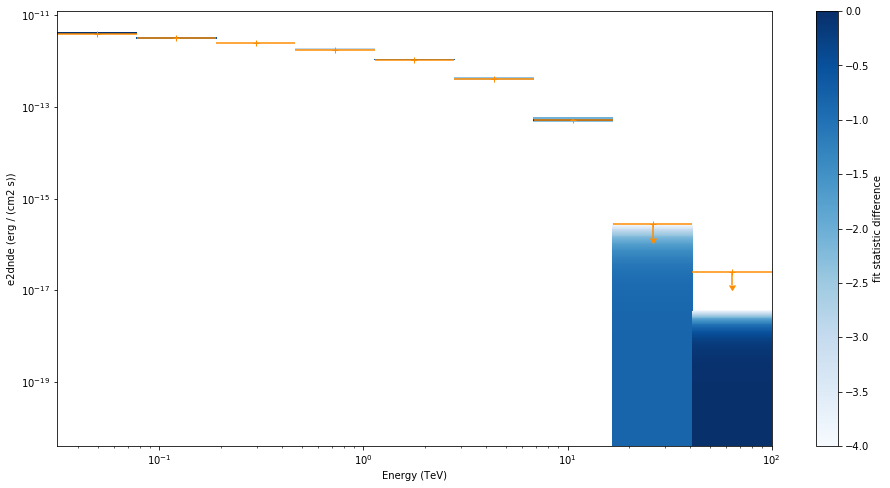

In [38]:
plt.figure(figsize=(16, 8))
flu_pois.table["is_ul"] = flu_pois.table["ts"] < 4
ax = flu_pois.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flu_pois.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [39]:
flu_pois_dataset = FluxPointsDataset(
    data=flu_pois, models=model_best_joints[124]
)

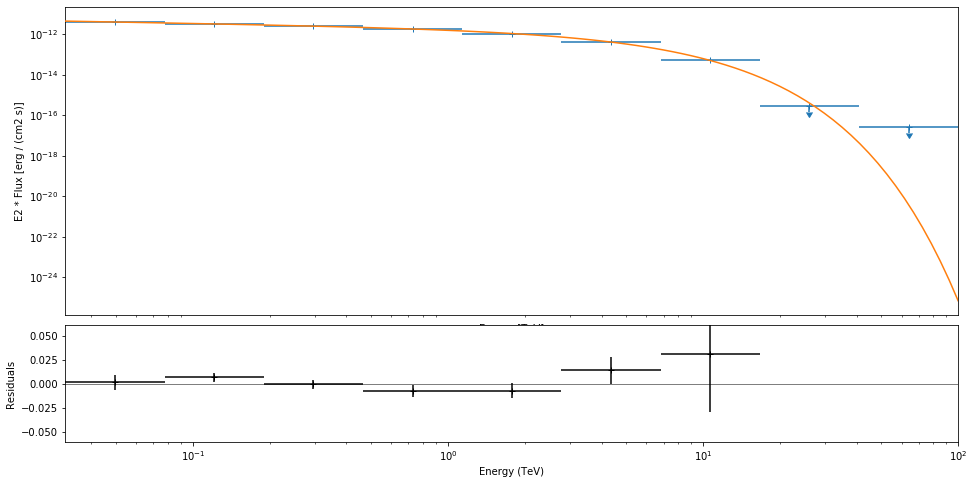

In [40]:
plt.figure(figsize=(16, 8))
flu_pois_dataset.peek();

<function matplotlib.pyplot.show(*args, **kw)>

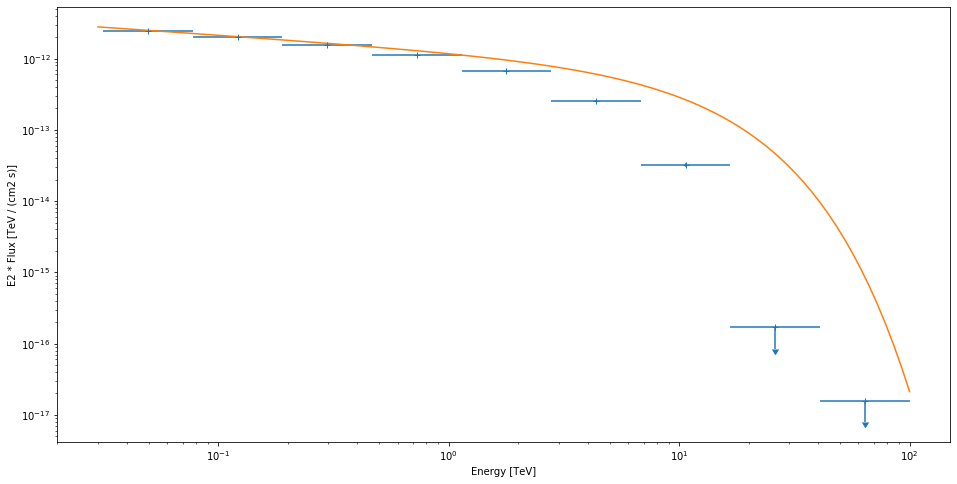

In [41]:
plt.figure(figsize=[16,8])
flu_pois.plot(energy_power=2)
simu.plot(energy_range=energy_range, energy_power=2)
plt.show